# **OCR Model for Text-based CAPTCHA Recognition**
_Alfredo Villasenor-Monsivais_<br>
_Alejandra G. Silva-Trujillo_

#### **Necessary imports:**

In [ ]:
import cv2
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

In [ ]:
from keras import layers
from keras import models
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### **Load and Pre-process the dataset:**

Download the following files in [Kaggle](https://www.kaggle.com/datasets/crawford/emnist/data):
- emnist-byclass-train.csv
- emnist-byclass-test.csv
- emnist-byclass-mapping.txt


In [ ]:
train_data = pd.read_csv("./dataset/emnist-byclass-train.csv", header = None)
test_data = pd.read_csv("./dataset/emnist-byclass-test.csv", header = None)
map_data = np.loadtxt('./dataset/emnist-byclass-mapping.txt', dtype = int, usecols = (1), unpack = True)

train_images = train_data.iloc[:,1:].values
train_labels = train_data.iloc[:,0].values

test_images = test_data.iloc[:,1:].values
test_labels = test_data.iloc[:,0].values

train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

def transformations(images):
    transformed_images = []
    for image in images:
        image = np.fliplr(image)
        image = np.rot90(image)
        transformed_images.append(image)
    return np.array(transformed_images)

train_images = transformations(train_images)
test_images = transformations(test_images)

train_images = train_images.reshape((697932, 784))
test_images = test_images.reshape((116323, 784))

#### **Model architecture:**
![Descripción de la imagen](./assets/cnn.jpg)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1), padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(62, activation = 'softmax'))

model.summary()

#### **Compile the model:**

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#### **Train and Save the model:**

In [ ]:
history = model.fit(train_images, train_labels, epochs = 20, batch_size = 128)
model.save('./model/emnist_model.h5')

#### **Evaluate the model:**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

#### **Show the model history graphs:**

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

#### **Make the test set predictions and show the confusion matrix:**

In [ ]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis = 1)
test_labels = np.argmax(test_labels, axis = 1)

class_names = [chr(c) for c in map_data]

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names, annot_kws = {"size": 7})
plt.xticks(fontsize = 10)
plt.yticks(rotation = 90, fontsize = 10)
plt.xlabel('Predicted  labels', fontsize = 12)
plt.ylabel('True labels', fontsize = 12)
plt.show()

#### **Load the model:**

In [ ]:
model = load_model('./model/emnist_model.h5')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

map_data = np.loadtxt('./dataset/emnist-byclass-mapping.txt', dtype = int, usecols = (1), unpack = True)

#### **Choose an image to predict:**

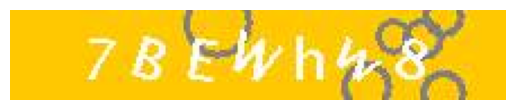

In [35]:
image = cv2.imread("./assets/CaptchaServlet.jpeg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### **Pre-process the image:**

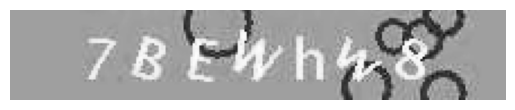

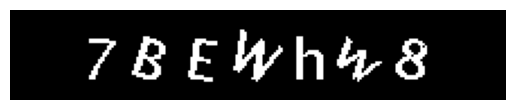

In [36]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

_, mask = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

#### **Image segmentation:**

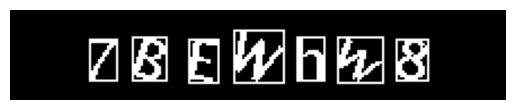

In [37]:
thresh = mask.copy()

contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[1] if imutils.is_cv3() else contours[0]

letter_image_regions = []

for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)

    letter_image_regions.append((x, y, w, h))

letter_image_regions = sorted(letter_image_regions, key = lambda x: x[0])

output_img = cv2.merge([thresh])

for (x, y, w, h) in letter_image_regions:
    cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 1)

plt.imshow(output_img, cmap='gray')
plt.axis('off')
plt.show()

#### **Make the characters' predictions:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


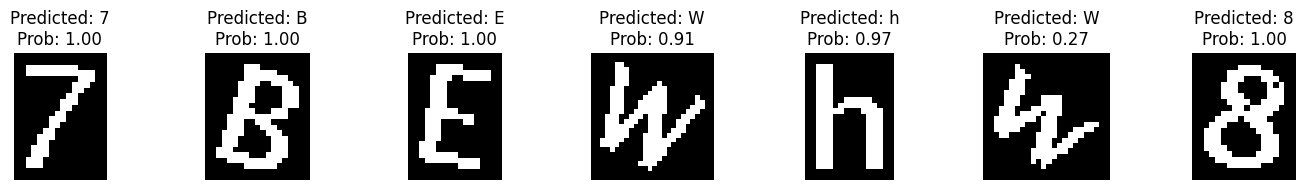

In [38]:
predicted_labels = []
characters = []

for region in letter_image_regions:
    x, y, w, h = region

    character = thresh[y - 2:y + h + 2, x - 2:x + w + 2]

    character = cv2.resize(character, (28, 28))

    character = character.astype('float32') / 255.0

    character = character.reshape((1, 784))
    
    characters.append(character)

characters = np.concatenate(characters, axis = 0)

predictions = model.predict(characters)

predicted_labels = np.argmax(predictions, axis = 1)
probabilities = np.max(predictions, axis = 1)

plt.figure(figsize = (len(predicted_labels) * 2, 2))

for i, (region, predicted_label, prob) in enumerate(zip(letter_image_regions, predicted_labels, probabilities), 1):
    x, y, w, h = region

    character = thresh[y - 2:y + h + 2, x - 2:x + w + 2]

    plt.subplot(1, len(predicted_labels), i)
    plt.imshow(character, cmap = 'gray')
    plt.title(f'Predicted: {chr(map_data[predicted_label])}\nProb: {prob:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()